# **Instance Segmentation with Detectron2**

---



# **What is detectron2 ?**

Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. It is the successor of **Detectron** and **maskrcnn-benchmark**. It supports a number of computer vision research projects and production applications in Facebook.

They provide a large set of baseline results and trained models available for download in the [Detectron2 Model Zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md).

---

# **Detectron2:**

All Detectron2 models were trained on train2017 and evaluated on val2017.

For **Faster/Mask R-CNN**, they provide baselines based on 3 different backbone combinations:

**FPN** (Feature Pyramid Network): Use a ResNet+FPN backbone with standard conv and FC heads for mask and box prediction, respectively. It obtains the best speed/accuracy tradeoff, but the other two are still useful for research.

**C4**: Use a ResNet conv4 backbone with conv5 head. The original baseline in the Faster R-CNN paper.

**DC5** (Dilated-C5): Use a ResNet conv5 backbone with dilations in conv5, and standard **conv** and **Fully Connected** heads for mask and box prediction, respectively. This is used by the Deformable ConvNet paper.
Most models are trained with the 3x schedule (~37 COCO epochs). 

Although 1x models are heavily under-trained, we provide some ResNet-50 models with the 1x (~12 COCO epochs) training schedule for comparison when doing quick research iteration.

---

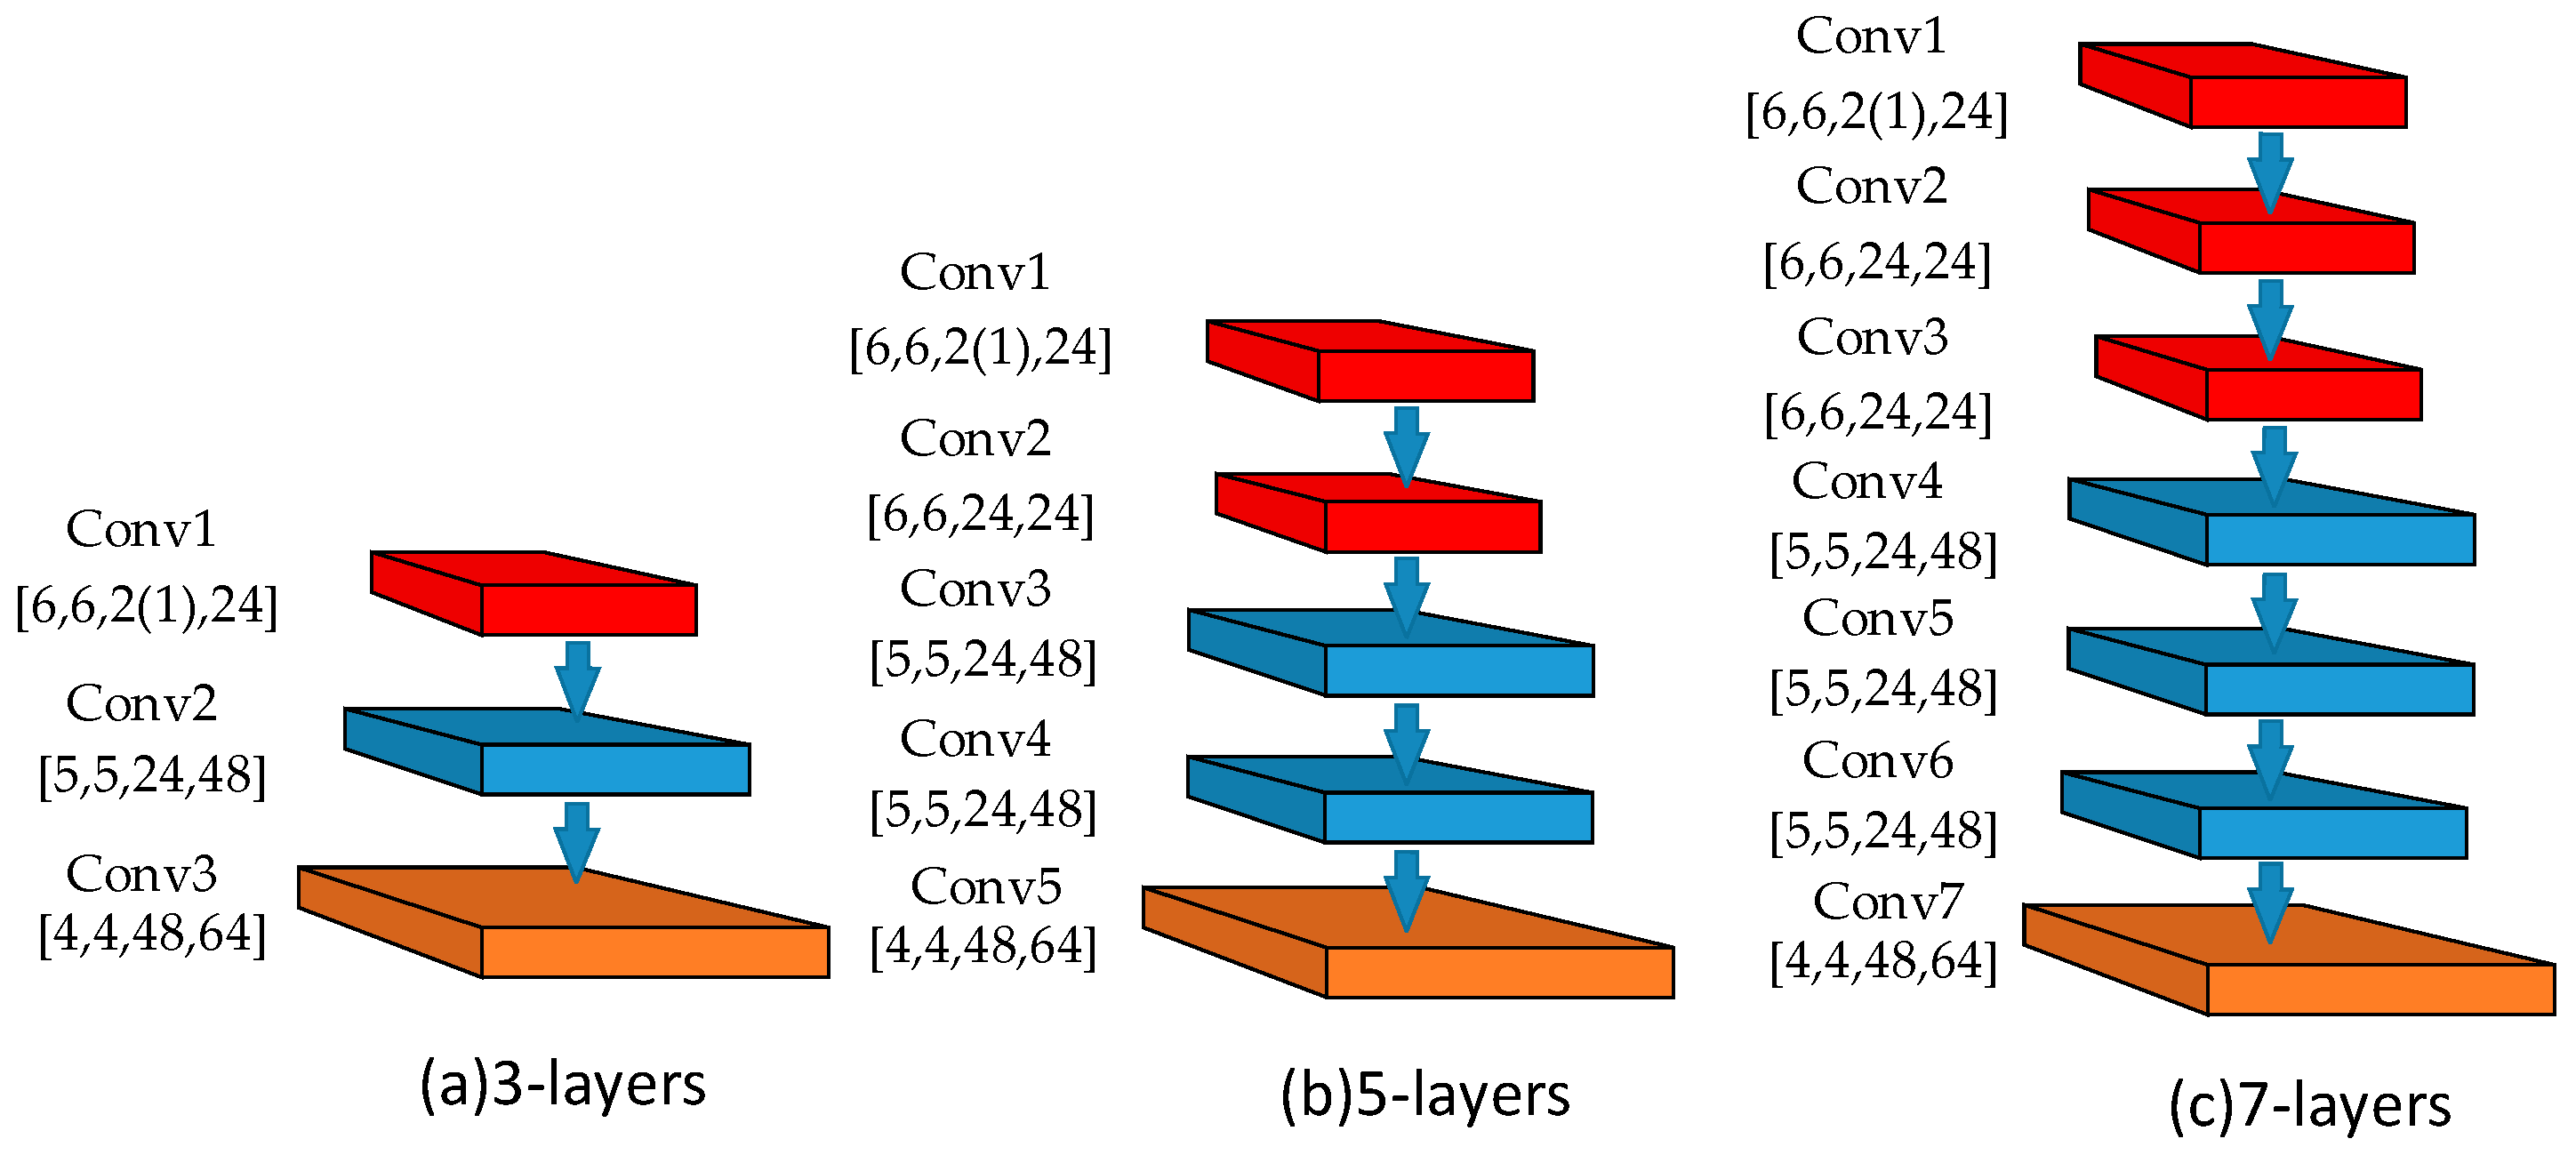

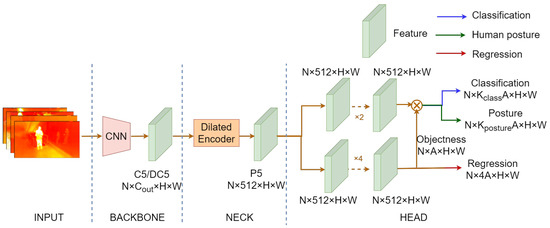

# **The final result we want to proceed to**

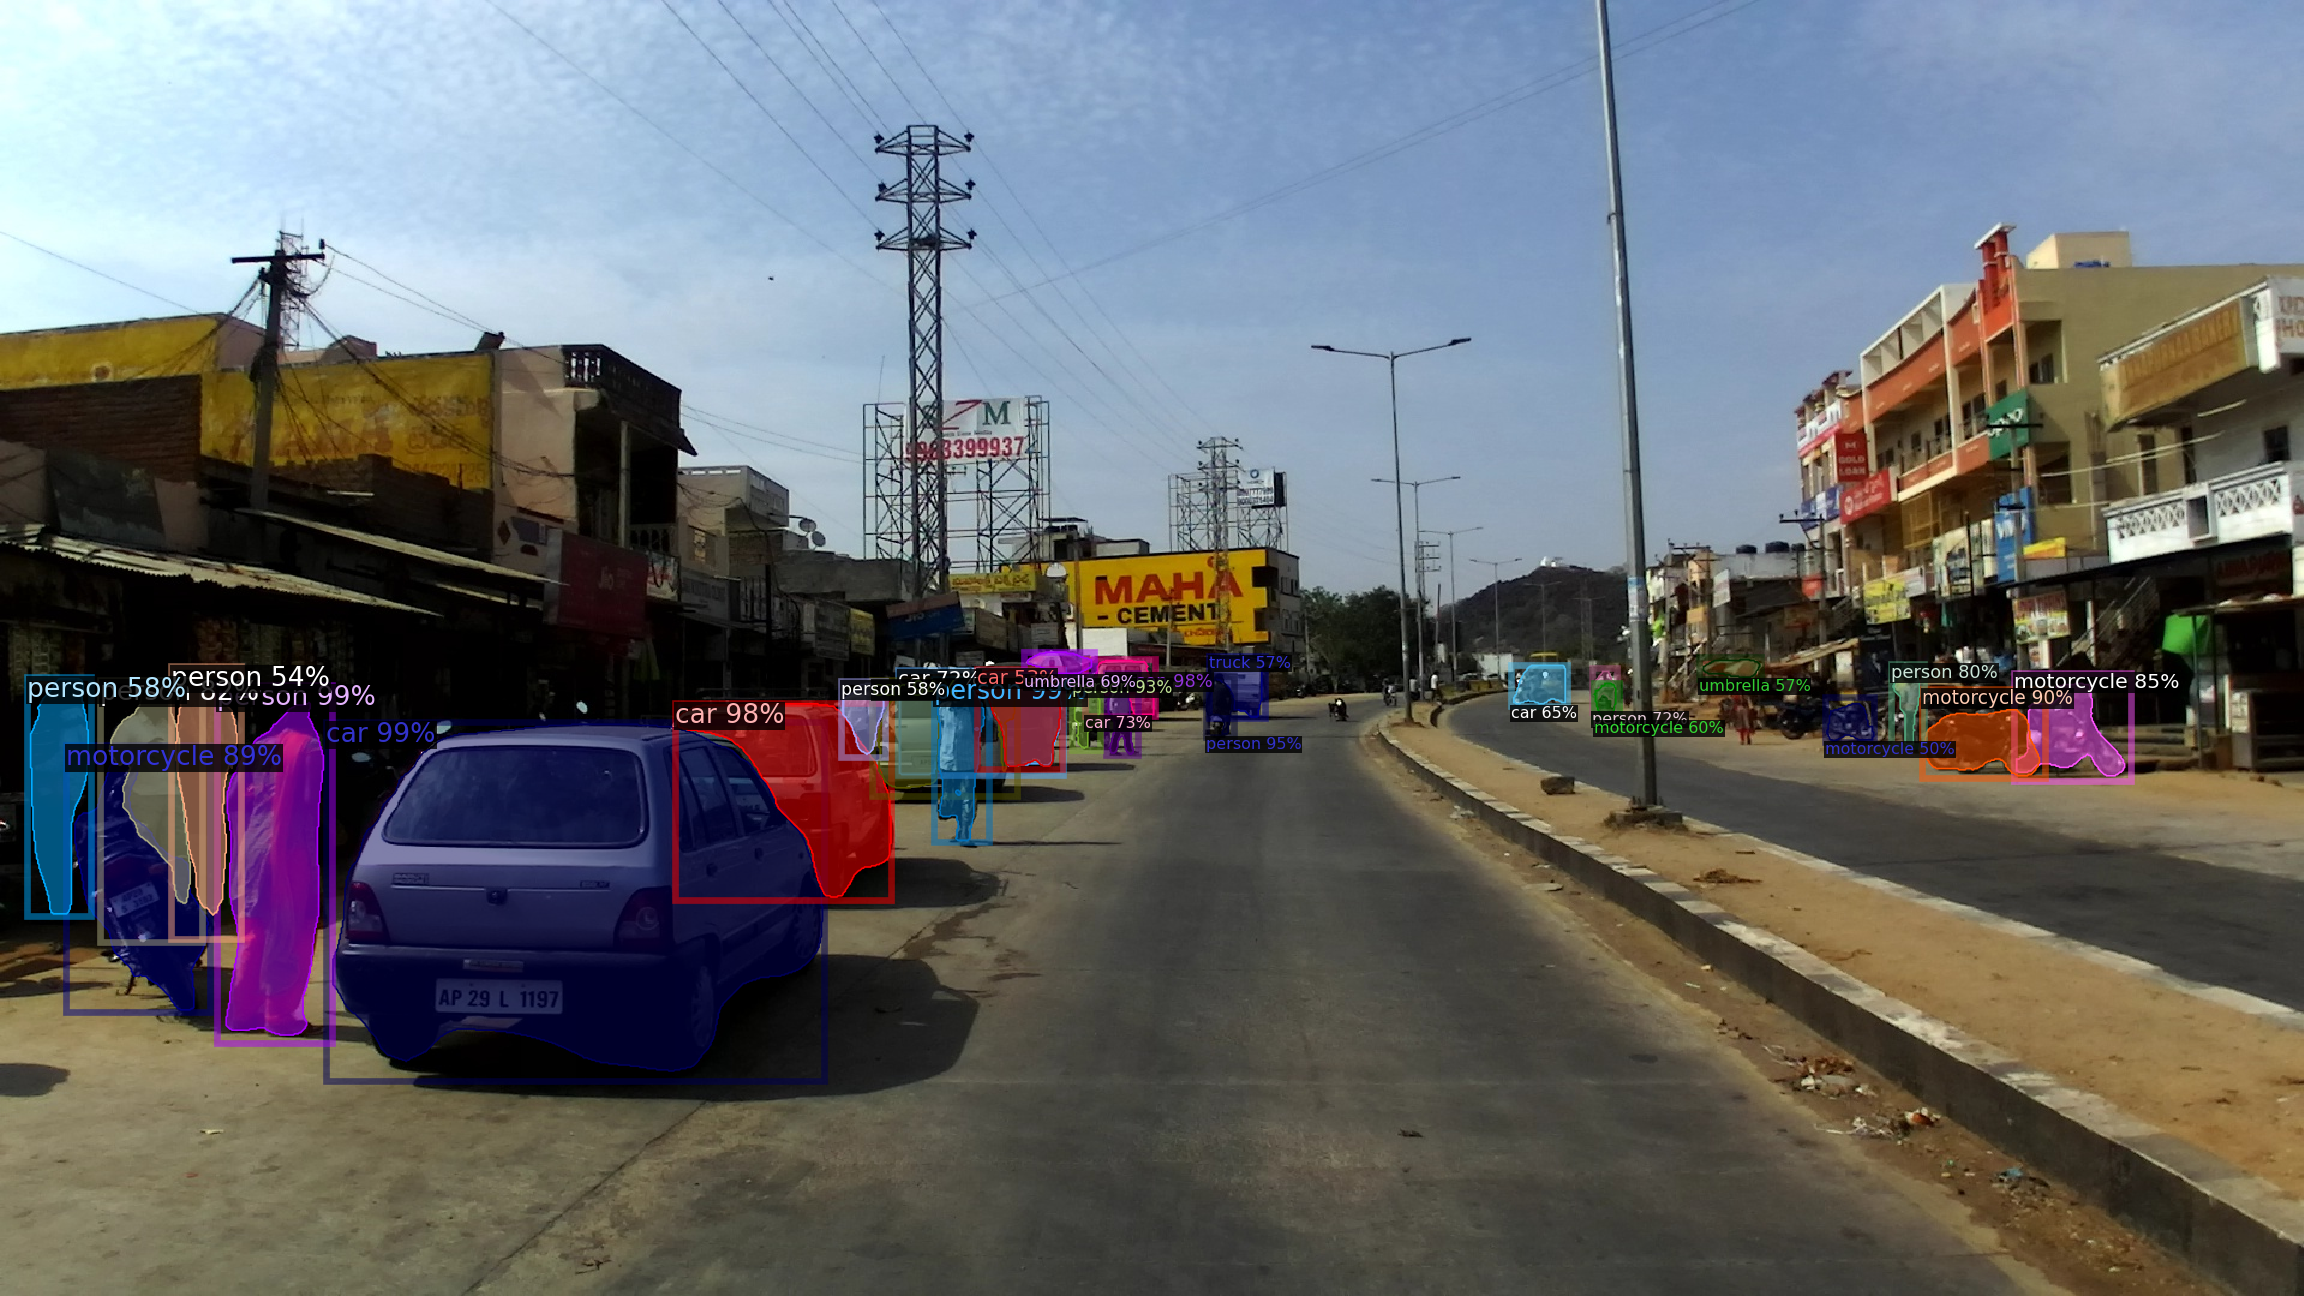

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# **Download the packages:**

---


In [ ]:
# Download detectron2 Model

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# **Import the packages**

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import tensorflow as tf

from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import torch, detectron2
import os

import json
import random
import shutil
import shapely.geometry
import matplotlib.pyplot as plt
%matplotlib inline
import random

#importing packages from detectron
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


# **Now we preprocess the data and json files into coco format** 
---



In [ ]:
#Checking if any value of the polygon is zero, let it equal 0.00001
#     in order to save the shape of the matrix

def check_if_zero(polygon):
  px=[]
  py=[]
  for a in polygon:
    if a[0] ==0.0:
      a[0]=0.00001
    if a[1]==0.0:
      a[1]=0.00001
    px.append(a[0])
    py.append(a[1])
  return (px,py)

In [ ]:
'''read the json file and convert it to coco format
    by extracting image name, image id, image height is the same in all pics= 1080 and image width is also the same in all pics=1920.
    Then, it loops among the objects of the photo extracting all objects and their polygons.
'''

def get_data_dicts(directory, classes):
    dataset_dicts = []
    idx = 0
    list_sorted = sorted([file for file in os.listdir(directory) if file.endswith('.json')])
    
    for idx, filename in enumerate(list_sorted):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        filename = os.path.join(directory, filename.split('_')[0]+"_leftImg8bit.jpg")

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 1080
        record["width"] = 1920
      
        annos = img_anns["objects"]
        objs = []
  
        for anno in annos:
          px,py=check_if_zero(anno['polygon'])
          poly = [(x, y) for x, y in zip(px, py)]
          poly = [p for x in poly for p in x]

          '''Here we check that length px, py are not equal zero (they are not empty), in order not to give us error'''
          if len(px)==0 or len(py)==0:
            continue
          else:
            obj = {
                  "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                  "bbox_mode": BoxMode.XYXY_ABS, 
                  "segmentation": [poly],
                  "category_id": classes.index(anno['label']),
                                  "iscrowd": 0
              }
          objs.append(obj)
          record["annotations"] = objs
          
          dataset_dicts.append(record)
    return dataset_dicts

# **Transfering the data in the same new folders**

---



In [ ]:
'''Here we transfere the images and the json files in one folder to ease the access to them.
Also, we took a part only from the data due to lack of computational power that kaggle and colab provides.'''

try:
  os.mkdir("/kaggle/working/train/")
  os.mkdir("/kaggle/working/val/")
except:
  pass
count=1
origin = '/kaggle/input/indian-driving-dataset/idd20kII/gtFine/train'
target = '/kaggle/working/train'
for subdir, dirs, files in os.walk(origin):
        for d in files:
            if count==1:
                count+=1
                continue
            if int(subdir.split('/')[7])<=206:
                shutil.copy(origin+'/'+subdir.split('/')[7]+'/'+d, target)
count=1
origin = '/kaggle/input/indian-driving-dataset/idd20kII/leftImg8bit/train'
for subdir, dirs, files in os.walk(origin):
        for d in files:
            if count==1:
                count+=1
                continue
            if int(subdir.split('/')[7])<=206:
                shutil.copy(origin+'/'+subdir.split('/')[7]+'/'+d, target)

count=1
origin = '/kaggle/input/indian-driving-dataset/idd20kII/gtFine/val'
target = '/kaggle/working/val'
for subdir, dirs, files in os.walk(origin):
            for d in files:
                shutil.copy(origin+'/'+subdir.split('/')[7]+'/'+d, target)
count=1
origin = '/kaggle/input/indian-driving-dataset/idd20kII/leftImg8bit/val'
for subdir, dirs, files in os.walk(origin):
            for d in files:
                shutil.copy(origin+'/'+subdir.split('/')[7]+'/'+d, target)

# **We know that we have 41 classes of different objects like road, person and motor cycle..etc. So we have to incude these with the images in a dictionary.**

---



<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
classes =  ['road','parking','drivable fallback','sidewalk','non-drivable fallback','rail track', 
            'person', 'animal', 'rider', 'motorcycle', 'bicycle', 'autorickshaw', 'car',
            'truck','bus','vehicle fallback','trailer','caravan','curb','wall','fence','guard rail', 
            'billboard','traffic sign', 'traffic light', 'pole', 'polegroup', 'obs-str-bar-fallback',
            'building', 'bridge', 'tunnel', 'vegetation', 'sky', 'fallback background',
            'unlabeled', 'out of roi','ego vehicle', 'ground','rectification border','train','license plate']

data_path = '/kaggle/working/'

'''registering each of the folders in a DatasetCatalog with the classes included'''
for d in ['train',"val"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes))

    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

In [ ]:
train_metadata=  MetadataCatalog.get("category_train")
val_metadata=  MetadataCatalog.get("category_val")
train_metadata

namespace(name='category_train',
          thing_classes=['road',
                         'parking',
                         'drivable fallback',
                         'sidewalk',
                         'non-drivable fallback',
                         'rail track',
                         'person',
                         'animal',
                         'rider',
                         'motorcycle',
                         'bicycle',
                         'autorickshaw',
                         'car',
                         'truck',
                         'bus',
                         'vehicle fallback',
                         'trailer',
                         'caravan',
                         'curb',
                         'wall',
                         'fence',
                         'guard rail',
                         'billboard',
                         'traffic sign',
                         'traffic light',
                         'pole'

# **Prepare configrations to train the model**

---


In [ ]:
def Train(NUM_WORKERS, IMS_PER_BATCH, BASE_LR, MAX_ITER, BATCH_SIZE_PER_IMAGE, NUM_CLASSES):
  
  cfg = get_cfg() #get configration
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # used from the pre-trained model
  cfg.DATASETS.TRAIN = ("category_train",) #used DatasetCategory that we made
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = NUM_WORKERS #number of workers
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # used from the pre-trained model 
  cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH #images per batch
  cfg.SOLVER.BASE_LR = BASE_LR #learning rate
  cfg.SOLVER.MAX_ITER = MAX_ITER  #number of iterations 
  cfg.SOLVER.STEPS = []     # 
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE  
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES 
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
  trainer = DefaultTrainer(cfg) 
  trainer.resume_or_load(resume=False)

  return cfg,trainer

In [ ]:
'''
 here we give the base model the needed arguments: Number of workers(turn on multi-process data loading with the specified number of loader worker processes),
 images per batch, learning rate, number of iterations, batch size per image(to sample a subset of proposals coming out of
 Region Proposal Network(is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position) 
 to calculate cls(classification) and reg loss during training) and the number of the classe.
'''

cfg,trainer = Train(2,2,0.00025, 2000,128, 41)

model_final_f10217.pkl: 178MB [00:00, 190MB/s]                             


In [ ]:
# then we train the model
trainer.train()

In [ ]:
#here we build the model structure and fills it with random parameters
model = trainer.build_model(cfg)

In [ ]:
model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [ ]:
#then we checkpoints the model
checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)

In [ ]:
#we retrieve the final weights and bias to test the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)

In [ ]:
#here we display our predicted images
def display_pred(image_path):
  im = cv2.imread(image_path)
  outputs = predictor(im)  
  v = Visualizer(im[:, :, ::-1],
                metadata=train_metadata, 
                scale=0.5, 
                instance_mode=ColorMode.IMAGE_BW 
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize=(10, 8))
  plt.axis('off')
  plt.imshow(out.get_image()[:, :, ::-1],) 
  plt.show();

# **The result that we went to:**

---



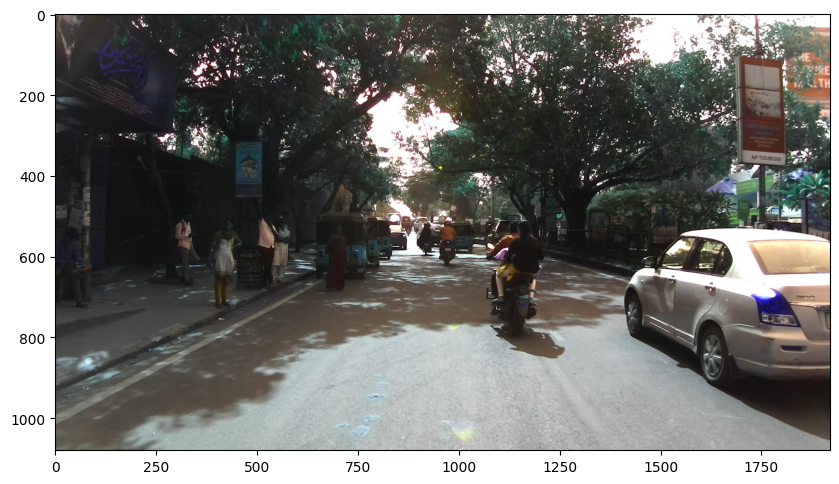

In [ ]:
im = cv2.imread('/kaggle/input/indian-driving-dataset/idd20kII/leftImg8bit/test/323/frame1210_leftImg8bit.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(im) 
plt.show();

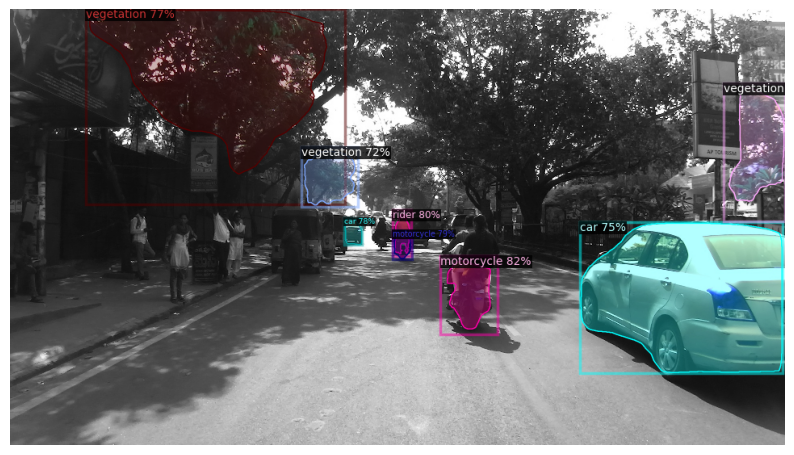

In [ ]:
display_pred('/kaggle/input/indian-driving-dataset/idd20kII/leftImg8bit/test/323/frame1210_leftImg8bit.jpg')

# **Here we evaluate the model and find the accuracy**

In [ ]:
# #Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("category_val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "category_val")

# #Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader)